In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

##################################################
# imports
##################################################

# full libraries
import pandas
import sklearn
import numpy as np
import os
import warnings
import seaborn as sns

# methods
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

from numpy import format_float_positional as sig

from scipy import stats
from scipy.stats import zscore



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/math482-2024-2025-1-hw-02-v2/sample_submission.csv
/kaggle/input/math482-2024-2025-1-hw-02-v2/train.csv
/kaggle/input/math482-2024-2025-1-hw-02-v2/test.csv


# Preprocessing
I start with prepocessing the data. 

First I will drop rows that are missing the target value and then drop rows that have 5 or more total missing values. Lastly I fill the remaining rows' missing values using the average of neighbours and a forward/backward fill to make sure every value in the dataframe exist.

In [2]:
# Read the data and shuffle it with a static random state.
data = pandas.read_csv("/kaggle/input/math482-2024-2025-1-hw-02-v2/train.csv")

# Drop rows that have missing target data.
print("Number of rows before dropping data with missing target=",len(data))
data.dropna(subset=["target"], inplace=True)
print("Number of rows after dropping data with missing target=",len(data))

# Drop rows that have too much missing data.
data.dropna(subset=data.columns[1:len(data.columns)], thresh=5, inplace=True)
print("Number of rows after dropping data with too many missing values=",len(data))

# Now apply filling techniques.
# Fill the missing data using average of neighbors
for col in data.columns:
    data[col] = data[col].fillna((data[col].shift(1) + data[col].shift(-1)) / 2)

# Fill remaining NaNs using forward and backward fill
data = data.ffill().bfill()

# Check to see if any null values left
print("Missing values left:")
print(data.isnull().sum())

# This will be used only in final model.
data_only_filled = data.copy()

Number of rows before dropping data with missing target= 35000
Number of rows after dropping data with missing target= 35000
Number of rows after dropping data with too many missing values= 35000
Missing values left:
id            0
feature_01    0
feature_02    0
feature_03    0
feature_04    0
feature_05    0
feature_06    0
feature_07    0
feature_08    0
feature_09    0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
feature_17    0
feature_18    0
feature_19    0
feature_20    0
feature_21    0
feature_22    0
feature_23    0
feature_24    0
feature_25    0
feature_26    0
feature_27    0
target        0
dtype: int64


Since there is no null value left, I continue with my procession.

I will now drop features with really small variance because I think they will not contribute to the model in a meaningful way.

In [3]:
# Setting up VarianceThreshold
# Threshold of 0 means features with zero variance will be removed
threshold = 0.1
selector = VarianceThreshold(threshold=threshold)
transformed_data = selector.fit_transform(data[data.columns[1:len(data.columns)-1]])

# Get the selected feature names
selected_features = data.columns[1:len(data.columns)-1][selector.get_support()]

# Create a new DataFrame with the selected features
df_transformed = pandas.DataFrame(transformed_data, columns=selected_features)

data = pandas.concat([data[data.columns[0]], df_transformed, data[data.columns[len(data.columns)-1]]], axis=1) # concatenating along columns
data

,id,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,...,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,target
0,1,262.108596,-89.894193,167.904794,-140202.616462,-402.804373,-70.271497,-71.722511,247.294897,-46.345927,...,30777.337175,32.459544,-0.973531,20.972532,35.643581,-266.077043,-30.308368,6.474833,268.632771,0
1,2,426.918262,-38.046964,67.708543,-179663.370518,-274.514081,85.215962,86.651628,60.284578,-179.844041,...,-14253.863293,528.263166,2.318207,-277.914322,-127.031012,-349.114898,-27.902697,4.592409,7.762922,0
2,3,26.396923,-17.890364,-6.928980,-5232.595711,-28.059078,169.993086,-2.235779,-41.395950,90.269368,...,-1864.472190,492.763499,-1.407389,102.519763,-62.966699,144.731707,71.979399,163.785203,12.363607,0
3,4,38.882727,145.266810,73.521560,16073.764144,-109.137905,15.990161,27.174344,329.749882,62.078654,...,24420.553595,285.815105,0.655909,33.491158,-125.407409,137.995067,19.900097,335.737907,-96.234018,1
4,5,-121.406525,-6.326038,-184.656875,-8839.800542,56.735282,67.911721,-79.757063,-197.434546,314.403055,...,-11489.914208,-133.541579,-0.449478,206.486620,304.595560,98.408951,-15.239702,-95.526909,113.631796,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,34996,-30.982277,160.858038,-3.004035,18703.955304,-76.278033,235.802449,-15.857158,-228.700268,44.721953,...,7659.274084,-136.336619,0.493791,13.282155,155.015405,-125.627600,14.863448,-84.214878,23.677131,0
34996,34997,200.394831,-38.395565,-11.970253,-19155.794409,-311.769109,124.251728,53.045065,216.830087,-198.502522,...,46108.014012,150.768761,-0.926864,56.211115,10.123346,488.316937,-28.120023,102.624099,-88.040936,3
34997,34998,-41.803240,-11.096508,114.995609,-35356.214360,-174.396387,259.093473,-57.516301,34.737993,36.878197,...,876.401047,-201.295427,-0.118266,52.842315,-92.204274,73.130302,71.489930,40.856904,77.727712,0
34998,34999,180.036464,100.624851,28.724963,-64702.740967,-323.380134,118.648912,48.725999,28.884704,-30.098856,...,39262.728038,237.223015,-0.107561,-2.943266,-41.633400,-128.442606,52.914212,96.037060,4.929937,0


There weren't any such features so no changes were made.

I now create a very sensitive Pearson Correlation Matrix first and a relaxed version after to check correlation of features and manually get rid of features that possibly are not related and included by mistake.

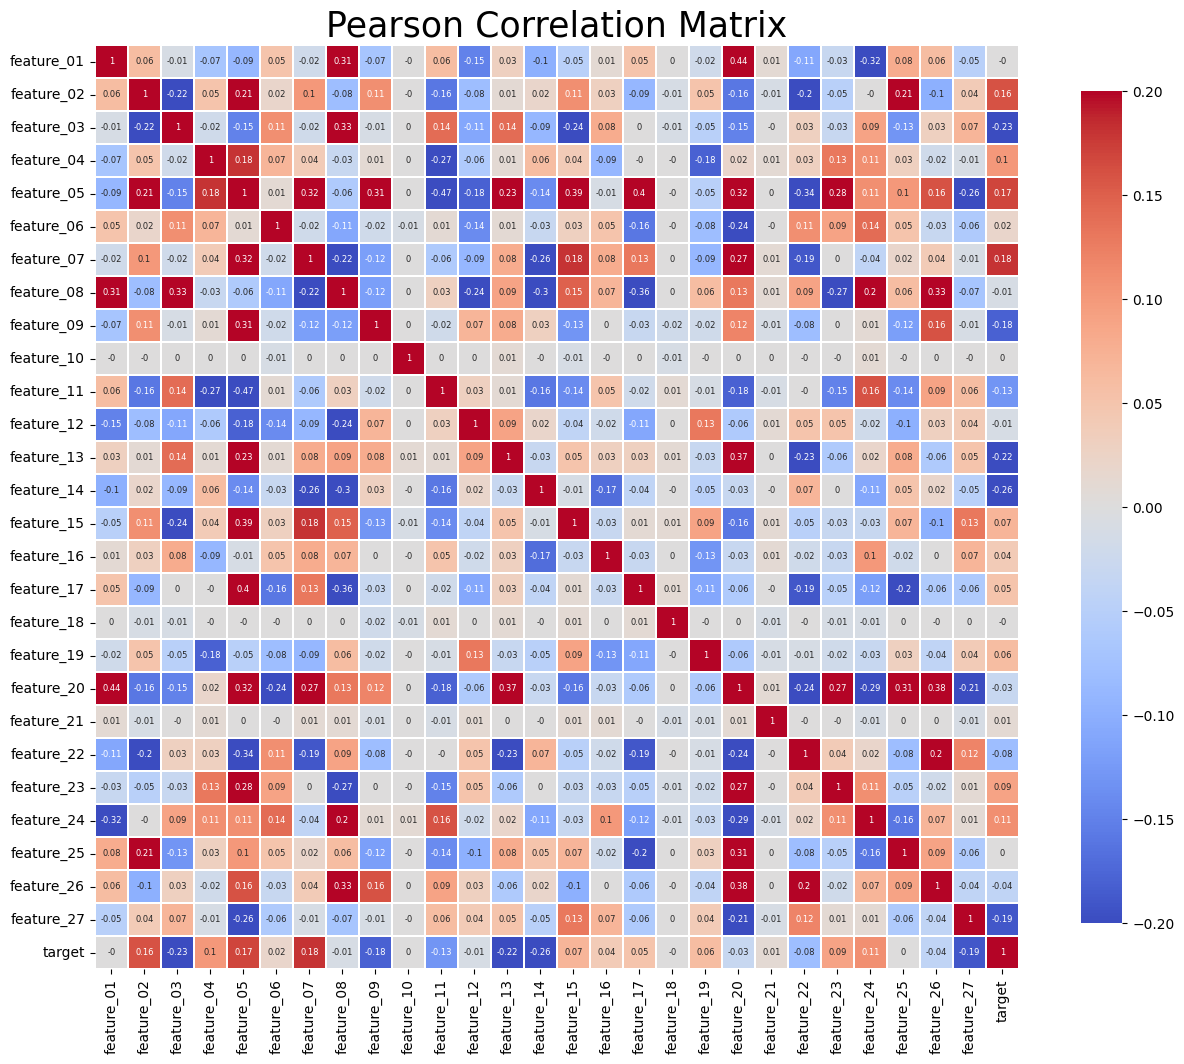

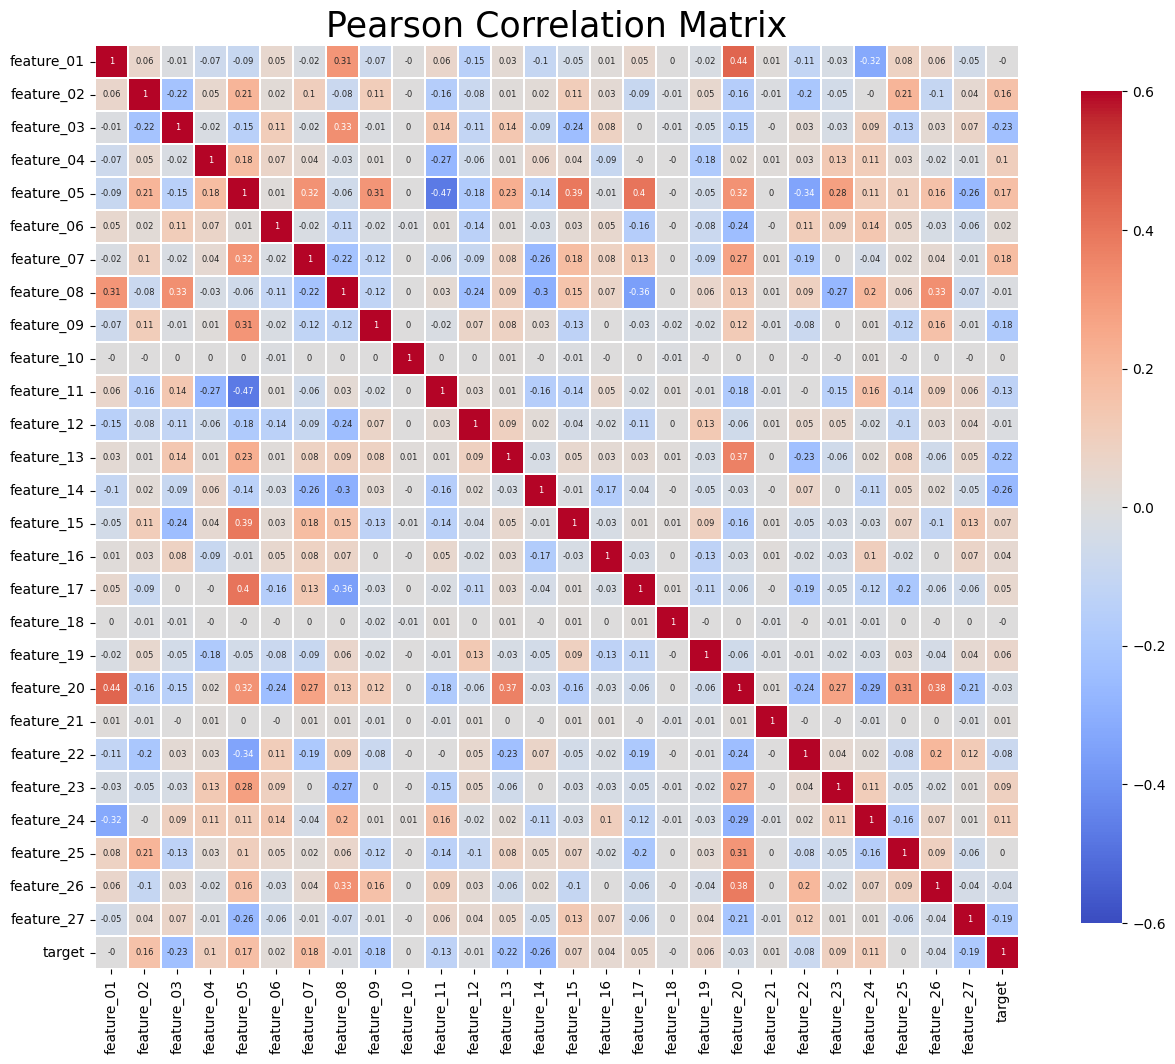

In [4]:
features_and_target = data.columns[1:29] # ["feature_01","feature_02",...,"feature_27","target"]

mask = np.zeros_like(data[features_and_target].corr().apply(lambda x: round(x, 2)), dtype=bool)

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(data[features_and_target].corr().apply(lambda x: round(x, 2)),
            linewidths=0.25,vmax=0.2,vmin=-0.2,square=True,cmap="coolwarm",
            linecolor='w',annot=True,annot_kws={"size":6},mask=mask,cbar_kws={"shrink": .9})
plt.show()


mask = np.zeros_like(data[features_and_target].corr().apply(lambda x: round(x, 2)), dtype=bool)

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(data[features_and_target].corr().apply(lambda x: round(x, 2)),
            linewidths=0.25,vmax=0.6,vmin=-0.6,square=True,cmap="coolwarm",
            linecolor='w',annot=True,annot_kws={"size":6},mask=mask,cbar_kws={"shrink": .9})
plt.show()

Features 10, 18, 21 seems irrelevant as they do not correlate with the target or any of the other features. These will be culled.

Some features seem to not have much effect on the outcome but since they have some correlation with multiple features, I will keep them in hopes of better presicion and create an alternative version with those features culled as well.

In [5]:
data.drop(["feature_10","feature_18","feature_21"], axis=1,inplace=True)
more_culled_data = data.copy()
more_culled_data.drop(["feature_01","feature_08","feature_12","feature_25"], axis=1,inplace=True)

With that out of the way, I will now check for linear dependence of columns and drop the ones that depend entirely on other columns.

In [6]:
print("Number of columns before linear dependence check=",len(data.columns))
# Function to check if a column is a linear combination of others using least_squares. 
# Not putting the functions right after import is considered a bad practice usually.
# But putting them at the top confuses me in the notebook environment.
def is_linear_combination_least_squares(df, target_col):
    y = df[target_col].values # Transforing for numpy use
    X = df.drop(columns=[target_col]).values

    # Solve the least squares problem
    weights, residuals, rank, s = np.linalg.lstsq(X, y, rcond=None)

    # Check if residuals are close to zero
    return np.allclose(residuals, 0)


# Iteratively check for and drop dependent columns
columns_to_check = list(data.columns[1:len(data.columns)-1])
dependent_columns = []

for col in columns_to_check:
    if is_linear_combination_least_squares(data, col):
        dependent_columns.append(col)
        # Drop the column if it is a linear combination
        data = data.drop(columns=[col])
print("Number of columns after linear dependence check=",len(data.columns))

Number of columns before linear dependence check= 26
Number of columns after linear dependence check= 26


I couldn't finy any such columns. For my next step in preprocession I will check for outliers and drop those that have a z-score of above 3. I will also create an alternative versions of data and more_culled_data that has their outliers replaced with mean values of each column instead of removing the outliers. Following codes will be lengthy but simple as it is repeated. In hindsight I should have wrote functions instead but now there are time constraints. All part of the learning process.

In [7]:
replaced_data = data.copy()

features = replaced_data.columns[1:len(replaced_data.columns)-1]
changes = 0
for feature in features:
    z_scores = replaced_data[features].apply(zscore)
    outliers = np.abs(z_scores[feature]) > 3
    outliers_count = np.sum(outliers) # The values are True and False .e. 1 and 0 so counting works.
    changes += outliers_count
    replaced_data.loc[outliers, feature] = replaced_data[feature].mean()
print("Total outliers replaced in data: ", changes)
replaced_data

Total outliers replaced in data:  8371


,id,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,...,feature_17,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,target
0,1,262.108596,-89.894193,167.904794,-140202.616462,-402.804373,-70.271497,-71.722511,247.294897,-46.345927,...,-76.409614,30777.337175,32.459544,20.972532,35.643581,-266.077043,-30.308368,6.474833,268.632771,0
1,2,426.918262,-38.046964,67.708543,-179663.370518,-274.514081,85.215962,86.651628,60.284578,-179.844041,...,52.045567,-14253.863293,528.263166,-277.914322,-127.031012,-349.114898,-27.902697,4.592409,7.762922,0
2,3,26.396923,-17.890364,-6.928980,-5232.595711,-28.059078,169.993086,-2.235779,-41.395950,90.269368,...,66.303003,-1864.472190,492.763499,102.519763,-62.966699,144.731707,71.979399,163.785203,12.363607,0
3,4,38.882727,145.266810,73.521560,16073.764144,-109.137905,15.990161,27.174344,329.749882,62.078654,...,-223.521324,24420.553595,285.815105,33.491158,-125.407409,137.995067,19.900097,335.737907,-96.234018,1
4,5,-121.406525,-6.326038,-184.656875,-8839.800542,56.735282,67.911721,-79.757063,-197.434546,314.403055,...,-202.511567,-11489.914208,-133.541579,206.486620,304.595560,98.408951,-15.239702,-95.526909,113.631796,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,34996,-30.982277,160.858038,-3.004035,18703.955304,-76.278033,235.802449,-15.857158,-228.700268,44.721953,...,-100.283462,7659.274084,-136.336619,13.282155,155.015405,-125.627600,14.863448,-84.214878,23.677131,0
34996,34997,200.394831,-38.395565,-11.970253,-19155.794409,-311.769109,124.251728,53.045065,216.830087,-198.502522,...,-147.865859,46108.014012,150.768761,56.211115,10.123346,488.316937,-28.120023,102.624099,-88.040936,3
34997,34998,-41.803240,-11.096508,114.995609,-35356.214360,-174.396387,259.093473,-57.516301,34.737993,36.878197,...,-5.245294,876.401047,-201.295427,52.842315,-92.204274,73.130302,71.489930,40.856904,77.727712,0
34998,34999,180.036464,100.624851,28.724963,-64702.740967,-323.380134,118.648912,48.725999,28.884704,-30.098856,...,-121.346758,39262.728038,237.223015,-2.943266,-41.633400,-128.442606,52.914212,96.037060,4.929937,0


In [8]:
replaced_more_culled_data = more_culled_data.copy()

features = replaced_more_culled_data.columns[1:len(replaced_more_culled_data.columns)-1]
changes = 0
for feature in features:
    z_scores = replaced_more_culled_data[features].apply(zscore)
    outliers = np.abs(z_scores[feature]) > 3
    outliers_count = np.sum(outliers) # The values are True and False .e. 1 and 0 so counting works.
    changes += outliers_count
    replaced_more_culled_data.loc[outliers, feature] = replaced_more_culled_data[feature].mean()
print("Total outliers replaced in data: ", changes)
replaced_more_culled_data

Total outliers replaced in data:  7264


,id,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_09,feature_11,feature_13,...,feature_16,feature_17,feature_19,feature_20,feature_22,feature_23,feature_24,feature_26,feature_27,target
0,1,-89.894193,167.904794,-140202.616462,-402.804373,-70.271497,-71.722511,-46.345927,348.178935,17.782590,...,1077.206161,-76.409614,30777.337175,32.459544,20.972532,35.643581,-266.077043,6.474833,268.632771,0
1,2,-38.046964,67.708543,-179663.370518,-274.514081,85.215962,86.651628,-179.844041,654.389909,249.747628,...,-355.926191,52.045567,-14253.863293,528.263166,-277.914322,-127.031012,-349.114898,4.592409,7.762922,0
2,3,-17.890364,-6.928980,-5232.595711,-28.059078,169.993086,-2.235779,90.269368,185.965922,184.548711,...,291.412674,66.303003,-1864.472190,492.763499,102.519763,-62.966699,144.731707,163.785203,12.363607,0
3,4,145.266810,73.521560,16073.764144,-109.137905,15.990161,27.174344,62.078654,-147.209919,-40.847273,...,-3973.125762,-223.521324,24420.553595,285.815105,33.491158,-125.407409,137.995067,335.737907,-96.234018,1
4,5,-6.326038,-184.656875,-8839.800542,56.735282,67.911721,-79.757063,314.403055,-155.754327,-255.324007,...,858.167161,-202.511567,-11489.914208,-133.541579,206.486620,304.595560,98.408951,-95.526909,113.631796,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,34996,160.858038,-3.004035,18703.955304,-76.278033,235.802449,-15.857158,44.721953,-245.091260,-121.088797,...,-2383.618742,-100.283462,7659.274084,-136.336619,13.282155,155.015405,-125.627600,-84.214878,23.677131,0
34996,34997,-38.395565,-11.970253,-19155.794409,-311.769109,124.251728,53.045065,-198.502522,61.319742,-211.384640,...,6509.278156,-147.865859,46108.014012,150.768761,56.211115,10.123346,488.316937,102.624099,-88.040936,3
34997,34998,-11.096508,114.995609,-35356.214360,-174.396387,259.093473,-57.516301,36.878197,202.571122,132.617951,...,1270.808005,-5.245294,876.401047,-201.295427,52.842315,-92.204274,73.130302,40.856904,77.727712,0
34998,34999,100.624851,28.724963,-64702.740967,-323.380134,118.648912,48.725999,-30.098856,200.219529,-60.606199,...,1868.768889,-121.346758,39262.728038,237.223015,-2.943266,-41.633400,-128.442606,96.037060,4.929937,0


Outlier dropped versions are created afterwards because I foolishly made them use the original data. This will not happen in later works.

Now I drop the outliers.

In [9]:
print("Number of rows before outlier check=",len(data))
# Specify the columns for outlier detection 
columns_to_check = data.columns[1:len(data.columns)-1]

# Calculate z-scores for the selected columns
z_scores = data[columns_to_check].apply(zscore)

# Define a threshold for outliers
threshold = 3

# Filter out rows with outliers in the specified columns
data = data[(np.abs(z_scores) < threshold).all(axis=1)]
print("Number of rows before after outlier check=",len(data))
data.reset_index(drop=True, inplace=True)

data

Number of rows before outlier check= 35000
Number of rows before after outlier check= 31349


,id,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,...,feature_17,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,target
0,1,262.108596,-89.894193,167.904794,-140202.616462,-402.804373,-70.271497,-71.722511,247.294897,-46.345927,...,-76.409614,30777.337175,32.459544,20.972532,35.643581,-266.077043,-30.308368,6.474833,268.632771,0
1,2,426.918262,-38.046964,67.708543,-179663.370518,-274.514081,85.215962,86.651628,60.284578,-179.844041,...,52.045567,-14253.863293,528.263166,-277.914322,-127.031012,-349.114898,-27.902697,4.592409,7.762922,0
2,3,26.396923,-17.890364,-6.928980,-5232.595711,-28.059078,169.993086,-2.235779,-41.395950,90.269368,...,66.303003,-1864.472190,492.763499,102.519763,-62.966699,144.731707,71.979399,163.785203,12.363607,0
3,4,38.882727,145.266810,73.521560,16073.764144,-109.137905,15.990161,27.174344,329.749882,62.078654,...,-223.521324,24420.553595,285.815105,33.491158,-125.407409,137.995067,19.900097,335.737907,-96.234018,1
4,5,-121.406525,-6.326038,-184.656875,-8839.800542,56.735282,67.911721,-79.757063,-197.434546,314.403055,...,-202.511567,-11489.914208,-133.541579,206.486620,304.595560,98.408951,-15.239702,-95.526909,113.631796,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31344,34996,-30.982277,160.858038,-3.004035,18703.955304,-76.278033,235.802449,-15.857158,-228.700268,44.721953,...,-100.283462,7659.274084,-136.336619,13.282155,155.015405,-125.627600,14.863448,-84.214878,23.677131,0
31345,34997,200.394831,-38.395565,-11.970253,-19155.794409,-311.769109,124.251728,53.045065,216.830087,-198.502522,...,-147.865859,46108.014012,150.768761,56.211115,10.123346,488.316937,-28.120023,102.624099,-88.040936,3
31346,34998,-41.803240,-11.096508,114.995609,-35356.214360,-174.396387,259.093473,-57.516301,34.737993,36.878197,...,-5.245294,876.401047,-201.295427,52.842315,-92.204274,73.130302,71.489930,40.856904,77.727712,0
31347,34999,180.036464,100.624851,28.724963,-64702.740967,-323.380134,118.648912,48.725999,28.884704,-30.098856,...,-121.346758,39262.728038,237.223015,-2.943266,-41.633400,-128.442606,52.914212,96.037060,4.929937,0


In [10]:
print("Number of rows before outlier check=",len(more_culled_data))
# Specify the columns for outlier detection 
columns_to_check = more_culled_data.columns[1:len(more_culled_data.columns)-1]

# Calculate z-scores for the selected columns
z_scores = more_culled_data[columns_to_check].apply(zscore)

# Define a threshold for outliers
threshold = 3

# Filter out rows with outliers in the specified columns
more_culled_data = more_culled_data[(np.abs(z_scores) < threshold).all(axis=1)]
print("Number of rows before after outlier check=",len(data))
more_culled_data.reset_index(drop=True, inplace=True)

more_culled_data

Number of rows before outlier check= 35000
Number of rows before after outlier check= 31349


,id,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_09,feature_11,feature_13,...,feature_16,feature_17,feature_19,feature_20,feature_22,feature_23,feature_24,feature_26,feature_27,target
0,1,-89.894193,167.904794,-140202.616462,-402.804373,-70.271497,-71.722511,-46.345927,348.178935,17.782590,...,1077.206161,-76.409614,30777.337175,32.459544,20.972532,35.643581,-266.077043,6.474833,268.632771,0
1,2,-38.046964,67.708543,-179663.370518,-274.514081,85.215962,86.651628,-179.844041,654.389909,249.747628,...,-355.926191,52.045567,-14253.863293,528.263166,-277.914322,-127.031012,-349.114898,4.592409,7.762922,0
2,3,-17.890364,-6.928980,-5232.595711,-28.059078,169.993086,-2.235779,90.269368,185.965922,184.548711,...,291.412674,66.303003,-1864.472190,492.763499,102.519763,-62.966699,144.731707,163.785203,12.363607,0
3,4,145.266810,73.521560,16073.764144,-109.137905,15.990161,27.174344,62.078654,-147.209919,-40.847273,...,-3973.125762,-223.521324,24420.553595,285.815105,33.491158,-125.407409,137.995067,335.737907,-96.234018,1
4,5,-6.326038,-184.656875,-8839.800542,56.735282,67.911721,-79.757063,314.403055,-155.754327,-255.324007,...,858.167161,-202.511567,-11489.914208,-133.541579,206.486620,304.595560,98.408951,-95.526909,113.631796,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31547,34996,160.858038,-3.004035,18703.955304,-76.278033,235.802449,-15.857158,44.721953,-245.091260,-121.088797,...,-2383.618742,-100.283462,7659.274084,-136.336619,13.282155,155.015405,-125.627600,-84.214878,23.677131,0
31548,34997,-38.395565,-11.970253,-19155.794409,-311.769109,124.251728,53.045065,-198.502522,61.319742,-211.384640,...,6509.278156,-147.865859,46108.014012,150.768761,56.211115,10.123346,488.316937,102.624099,-88.040936,3
31549,34998,-11.096508,114.995609,-35356.214360,-174.396387,259.093473,-57.516301,36.878197,202.571122,132.617951,...,1270.808005,-5.245294,876.401047,-201.295427,52.842315,-92.204274,73.130302,40.856904,77.727712,0
31550,34999,100.624851,28.724963,-64702.740967,-323.380134,118.648912,48.725999,-30.098856,200.219529,-60.606199,...,1868.768889,-121.346758,39262.728038,237.223015,-2.943266,-41.633400,-128.442606,96.037060,4.929937,0


Now that my data is nice and clean, I will check data distributions to see if any extra operation is required.

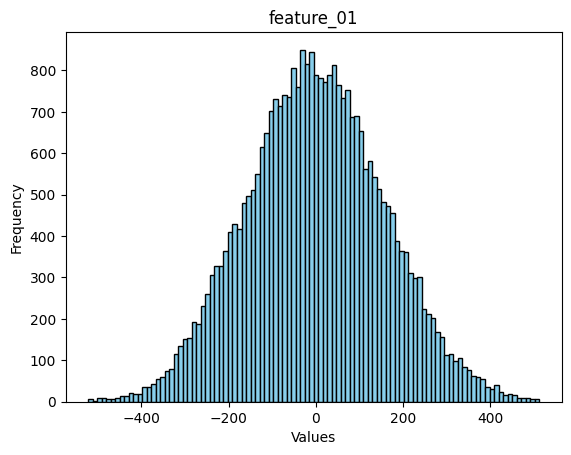

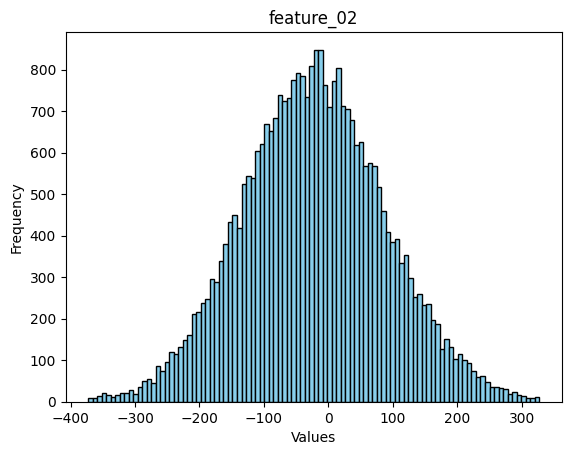

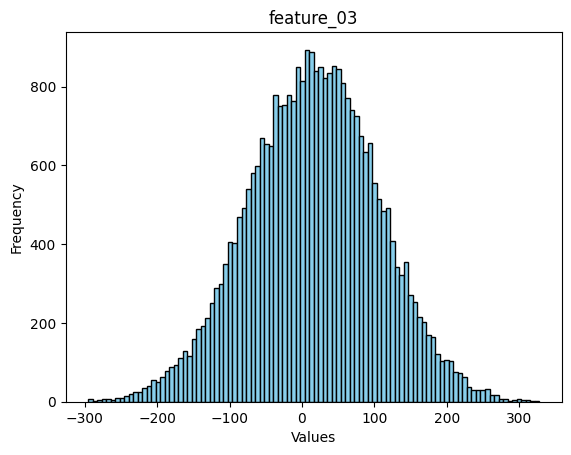

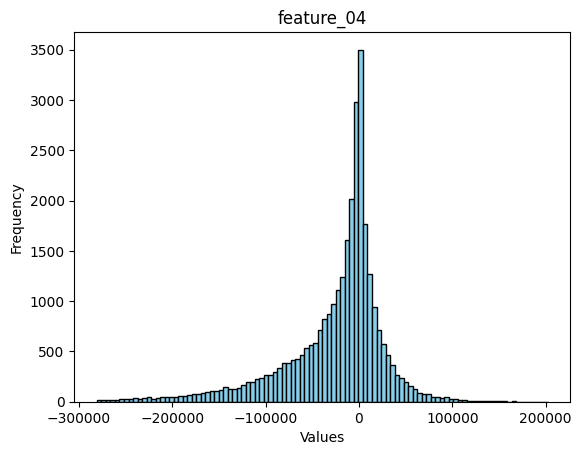

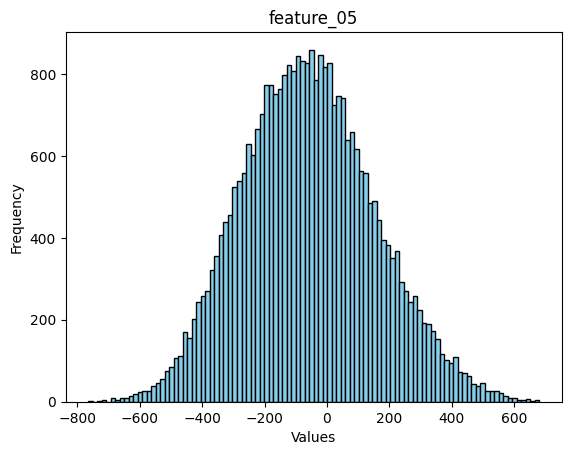

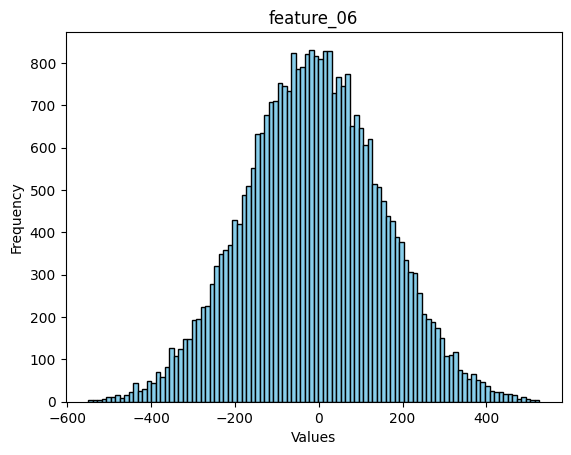

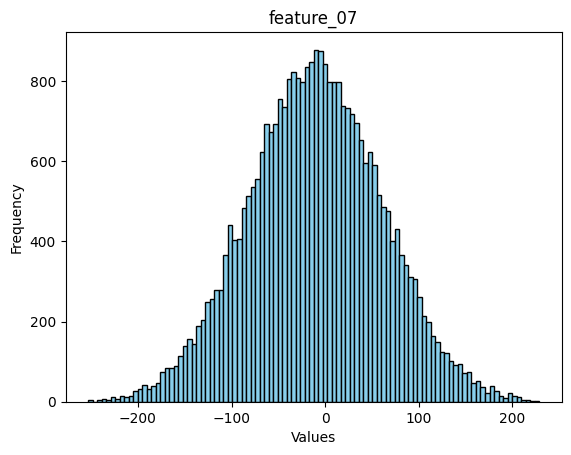

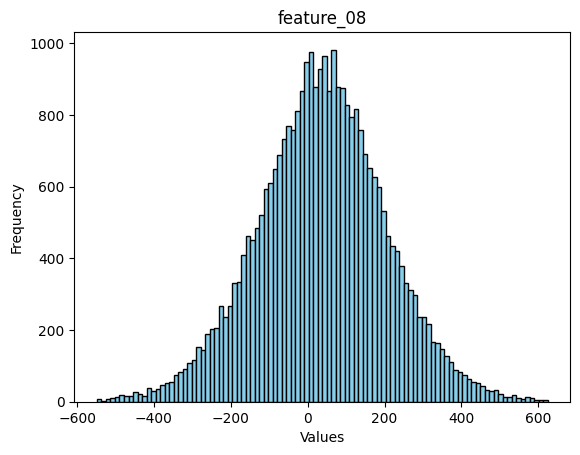

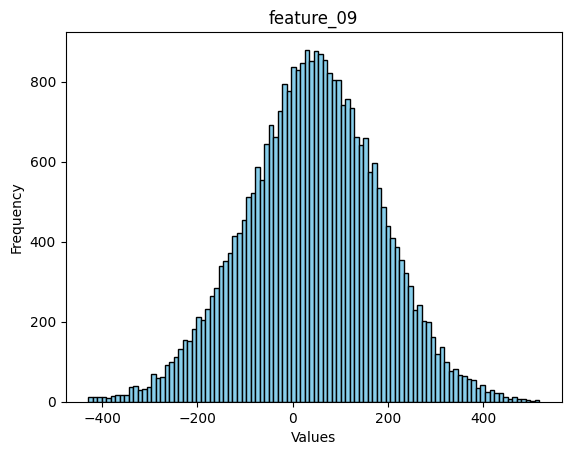

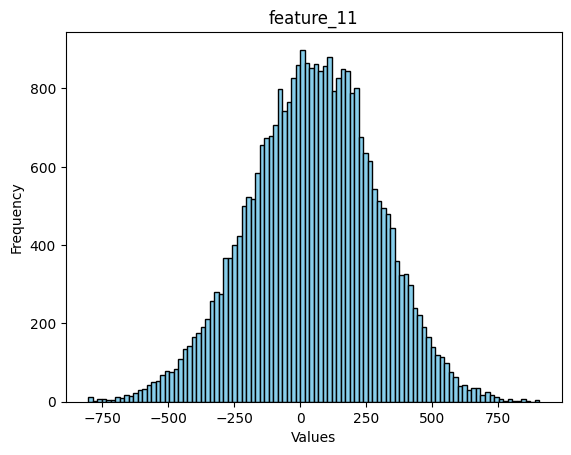

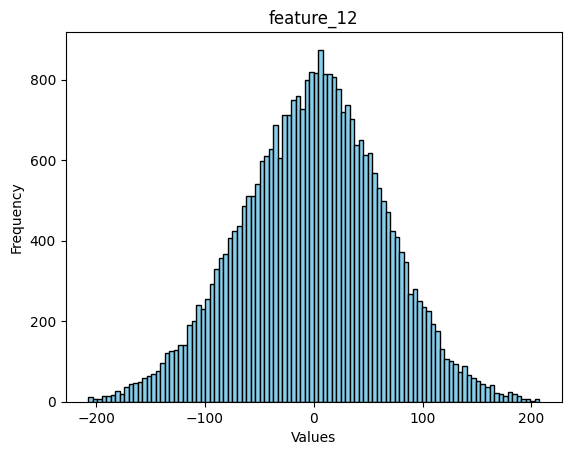

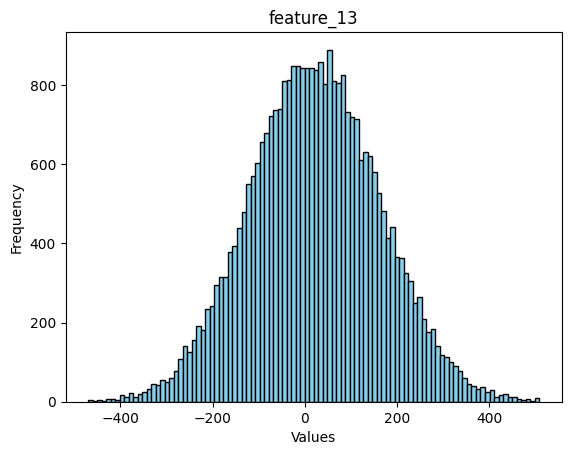

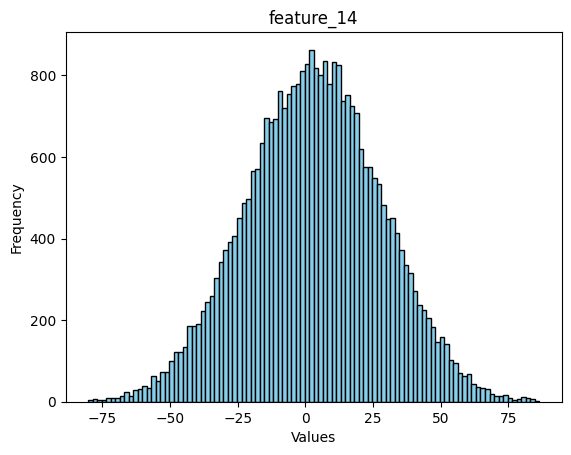

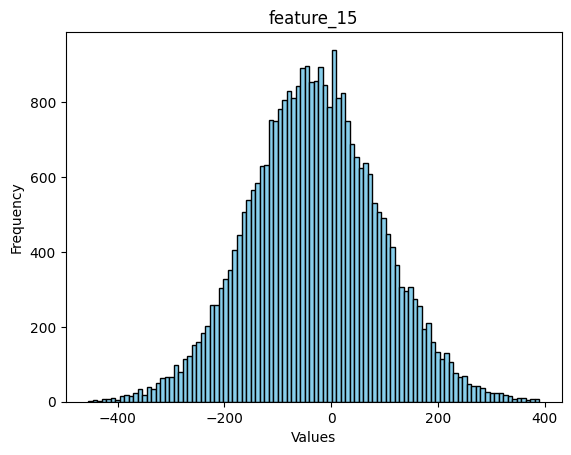

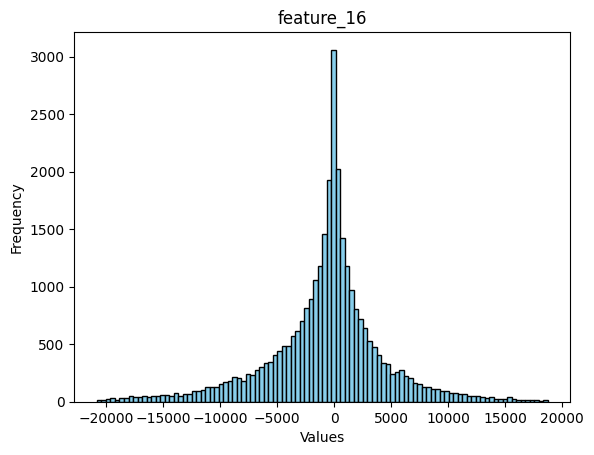

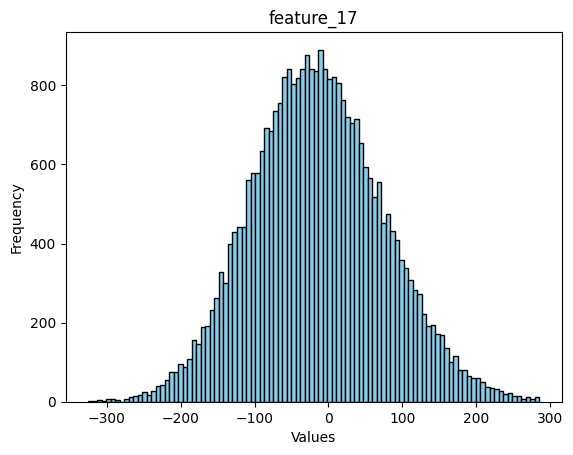

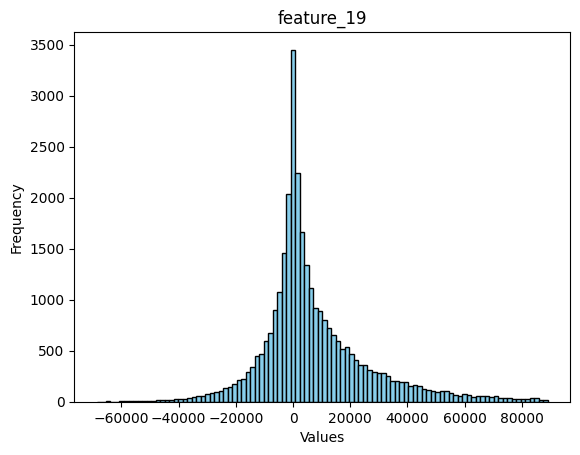

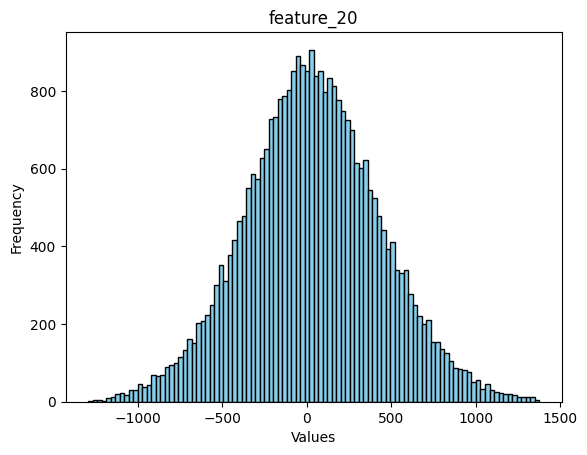

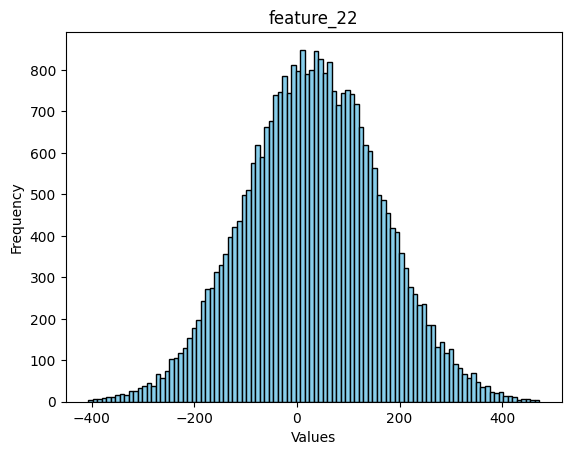

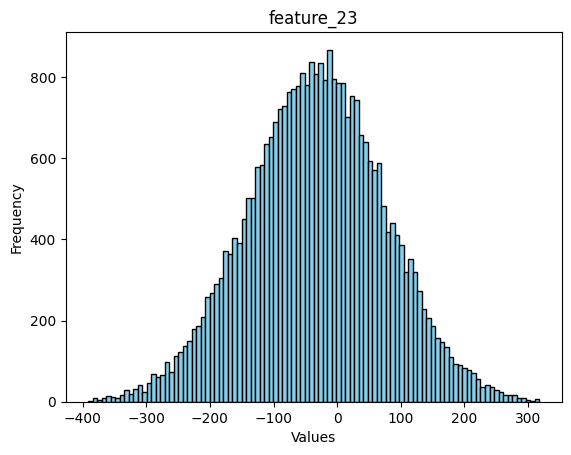

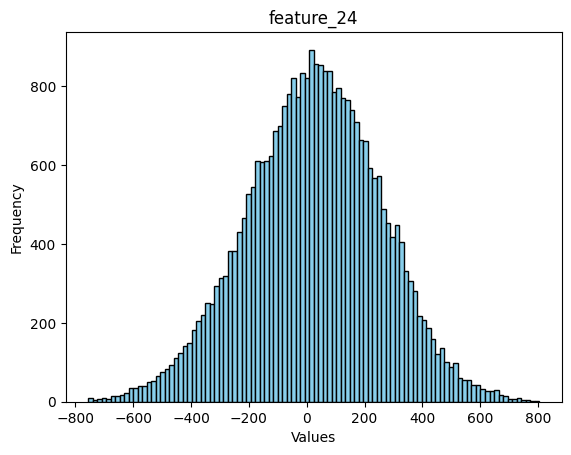

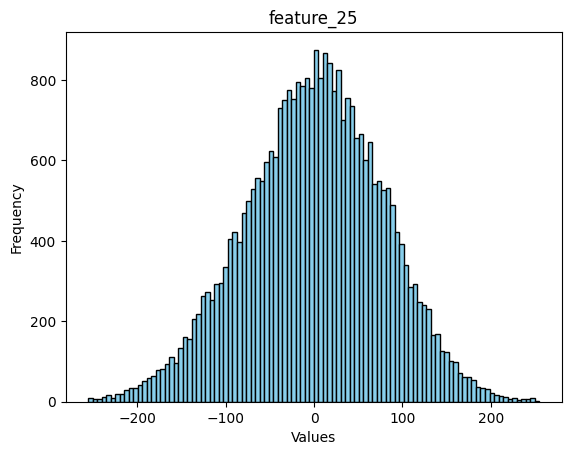

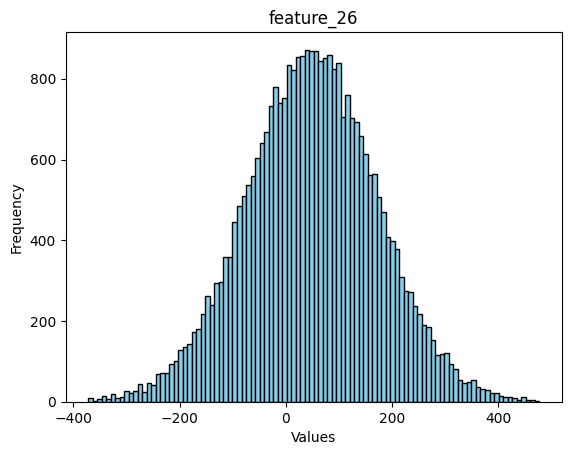

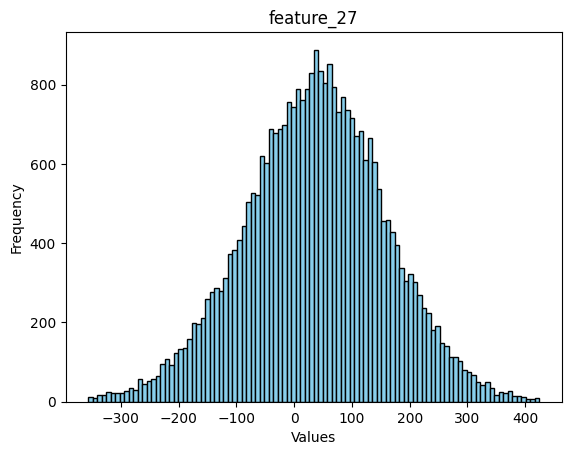

In [11]:
for i in range(1, len(data.columns)-1):
    plt.hist(data.iloc[:,i], bins=100, color='skyblue', edgecolor='black')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title(data.columns[i])
    plt.show()

The features seem normally distributed. I will go ahead standardize data for faster procession.

In [12]:
# Create StandardScaler instance
scaler = StandardScaler()

# Fit and transform the data
scaled_data = scaler.fit_transform(data[data.columns[1:len(data.columns)-1]])

# Convert the scaled data back to a DataFrame
scaled_data_df = pandas.DataFrame(scaled_data, columns=data.columns[1:len(data.columns)-1])

# Concatenating along columns
data = pandas.concat([data[data.columns[0]], scaled_data_df, data[["target"]]], axis=1) # concatenating along columns

data

,id,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,...,feature_17,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,target
0,1,1.667759,-0.609285,1.708569,-2.081162,-1.616924,-0.358463,-0.855442,1.263788,-0.627392,...,-0.692157,1.219395,-0.006753,-0.084993,0.638985,-1.250927,-0.387244,-0.337393,1.905762,0
1,2,2.712384,-0.140050,0.585525,-2.797029,-1.013530,0.595370,1.366486,0.145368,-1.575012,...,0.749806,-1.122815,1.229917,-2.350839,-0.868107,-1.608968,-0.356341,-0.352596,-0.234575,0
2,3,0.173731,0.042374,-0.251045,0.367362,0.145635,1.115432,0.119430,-0.462735,0.342355,...,0.909852,-0.478405,1.141371,0.533212,-0.274586,0.520386,0.926750,0.933103,-0.196829,0
3,4,0.252871,1.519003,0.650680,0.753886,-0.235707,0.170707,0.532043,1.756912,0.142246,...,-2.343546,0.888760,0.625185,0.009910,-0.853065,0.491339,0.257736,2.321856,-1.087830,1
4,5,-0.763102,0.147036,-2.243097,0.301923,0.544453,0.489218,-0.968163,-1.395927,1.933340,...,-2.107703,-0.979053,-0.420805,1.321380,3.130681,0.320653,-0.193671,-1.161196,0.634038,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31344,34996,-0.189960,1.660109,-0.207052,0.801601,-0.081156,1.519138,-0.071672,-1.582913,0.019042,...,-0.960150,0.016954,-0.427777,-0.143293,1.744901,-0.645341,0.193035,-1.069836,-0.104005,0
31345,34997,1.276594,-0.143205,-0.307550,0.114778,-1.188753,0.834834,0.894999,1.081592,-1.707456,...,-1.494283,2.016791,0.288343,0.182149,0.402554,2.001847,-0.359133,0.439144,-1.020609,3
31346,34998,-0.258547,0.103861,1.115539,-0.179118,-0.542641,1.662016,-0.656134,-0.007414,-0.036636,...,0.106692,-0.335844,-0.589802,0.156610,-0.545456,0.211657,0.920462,-0.059710,0.339459,0
31347,34999,1.147555,1.114978,0.148580,-0.711500,-1.243364,0.800463,0.834404,-0.042420,-0.512064,...,-1.196595,1.660746,0.503983,-0.266297,-0.076944,-0.657479,0.681838,0.385945,-0.257819,0


In [13]:
# Create StandardScaler instance
scaler = StandardScaler()

# Fit and transform the data
scaled_data = scaler.fit_transform(more_culled_data[more_culled_data.columns[1:len(more_culled_data.columns)-1]])

# Convert the scaled data back to a DataFrame
scaled_data_df = pandas.DataFrame(scaled_data, columns=more_culled_data.columns[1:len(more_culled_data.columns)-1])

# Concatenating along columns
more_culled_data = pandas.concat([more_culled_data[more_culled_data.columns[0]], scaled_data_df, more_culled_data[["target"]]], axis=1)
more_culled_data

,id,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_09,feature_11,feature_13,...,feature_16,feature_17,feature_19,feature_20,feature_22,feature_23,feature_24,feature_26,feature_27,target
0,1,-0.608062,1.700569,-2.080138,-1.616543,-0.358948,-0.854512,-0.624808,1.233195,-0.028526,...,0.358105,-0.691531,1.218083,-0.006096,-0.084766,0.637392,-1.249275,-0.336490,1.900554,0
1,2,-0.139844,0.582008,-2.795374,-1.013662,0.593757,1.361824,-1.570728,2.496564,1.612942,...,0.078747,0.745069,-1.119848,1.227284,-2.344807,-0.864404,-1.606627,-0.351637,-0.235042,0
2,3,0.042185,-0.251223,0.366227,0.144515,1.113205,0.117907,0.343199,0.563935,1.151571,...,0.204931,0.904519,-0.476616,1.138973,0.531855,-0.272969,0.518631,0.929347,-0.197379,0
3,4,1.515613,0.646903,0.752410,-0.236502,0.169596,0.529481,0.143450,-0.810687,-0.443411,...,-0.626347,-2.336780,0.888051,0.624161,0.009894,-0.849415,0.489640,2.313007,-1.086407,1
4,5,0.146620,-2.235323,0.300845,0.542993,0.487731,-0.966950,1.931331,-0.845939,-1.961125,...,0.315408,-2.101814,-0.976350,-0.419046,1.318003,3.120330,0.319282,-1.157272,0.631647,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31547,34996,1.656413,-0.207406,0.800083,-0.082083,1.516434,-0.072715,0.020467,-1.214527,-1.011229,...,-0.316507,-0.958529,0.017838,-0.425999,-0.142917,1.739421,-0.644854,-1.066247,-0.104761,0
31548,34997,-0.142992,-0.307502,0.113865,-1.188737,0.832938,0.891524,-1.702935,0.049668,-1.650195,...,1.416968,-1.490674,2.014021,0.288215,0.181691,0.401792,1.997243,0.437199,-1.019335,3
31549,34998,0.103539,1.109907,-0.179771,-0.543175,1.659143,-0.655706,-0.035111,0.632445,0.784090,...,0.395843,0.104347,-0.334315,-0.587593,0.156218,-0.542887,0.210496,-0.059826,0.337721,0
31550,34999,1.112464,0.146807,-0.711684,-1.243301,0.798608,0.831081,-0.509687,0.622742,-0.583233,...,0.512402,-1.194093,1.658627,0.503281,-0.265606,-0.076022,-0.656968,0.384194,-0.258234,0


In [14]:
# Create StandardScaler instance
scaler = StandardScaler()

# Fit and transform the data
scaled_data = scaler.fit_transform(replaced_data[replaced_data.columns[1:len(replaced_data.columns)-1]])

# Convert the scaled data back to a DataFrame
scaled_data_df = pandas.DataFrame(scaled_data, columns=replaced_data.columns[1:len(replaced_data.columns)-1])

# Concatenating along columns
replaced_data = pandas.concat([replaced_data[replaced_data.columns[0]], scaled_data_df, replaced_data[["target"]]], axis=1)
replaced_data

,id,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,...,feature_17,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,target
0,1,1.607461,-0.595364,1.638400,-1.884596,-1.434685,-0.333729,-0.809292,1.196837,-0.609391,...,-0.637720,1.136967,-0.004434,-0.075697,0.629966,-1.191189,-0.379671,-0.326004,1.844257,0
1,2,2.615569,-0.137737,0.566440,-2.545640,-0.894797,0.585746,1.312591,0.129946,-1.518639,...,0.700171,-1.094142,1.181863,-2.238533,-0.818547,-1.535916,-0.349715,-0.340596,-0.227512,0
2,3,0.165659,0.040173,-0.232077,0.376413,0.142367,1.087075,0.121685,-0.450141,0.321089,...,0.848665,-0.480299,1.096924,0.514403,-0.248095,0.514260,0.894042,0.893417,-0.190975,0
3,4,0.242032,1.480270,0.628631,0.733336,-0.198839,0.176379,0.515719,1.667242,0.129083,...,-2.169923,0.822015,0.601763,0.014891,-0.804090,0.486293,0.245537,2.226340,-1.053432,1
4,5,-0.738426,0.142245,-2.133516,0.315985,0.499210,0.483417,-0.916939,-1.340339,1.847651,...,-1.951102,-0.957199,-0.401621,1.266739,3.024812,0.321953,-0.192032,-1.116689,0.613274,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,34996,-0.185318,1.617885,-0.190085,0.777396,-0.060554,1.476239,-0.060813,-1.518710,0.010868,...,-0.886372,-0.008437,-0.408309,-0.131347,1.692896,-0.608122,0.182820,-1.029002,-0.101125,0
34996,34997,1.229970,-0.140814,-0.286011,0.143172,-1.051579,0.816584,0.862333,1.023036,-1.645721,...,-1.381954,1.896538,0.278641,0.179300,0.402725,1.940634,-0.352422,0.419315,-0.988365,3
34997,34998,-0.251508,0.100139,1.072346,-0.128216,-0.473469,1.613970,-0.618959,-0.015797,-0.042556,...,0.103473,-0.344500,-0.563734,0.154922,-0.508437,0.217010,0.887947,-0.059485,0.328132,0
34998,34999,1.105442,1.086240,0.149371,-0.619827,-1.100442,0.783452,0.804466,-0.049190,-0.498733,...,-1.105751,1.557382,0.485498,-0.248759,-0.058136,-0.619808,0.656638,0.368254,-0.250011,0


In [15]:
# Create StandardScaler instance
scaler = StandardScaler()

# Fit and transform the data
scaled_data = scaler.fit_transform(replaced_more_culled_data[replaced_more_culled_data.columns[1:len(replaced_more_culled_data.columns)-1]])

# Convert the scaled data back to a DataFrame
scaled_data_df = pandas.DataFrame(scaled_data, columns=replaced_more_culled_data.columns[1:len(replaced_more_culled_data.columns)-1])

# Concatenating along columns
replaced_more_culled_data = pandas.concat([replaced_more_culled_data[replaced_more_culled_data.columns[0]], 
                                           scaled_data_df, replaced_more_culled_data[["target"]]], axis=1)

replaced_more_culled_data

,id,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_09,feature_11,feature_13,...,feature_16,feature_17,feature_19,feature_20,feature_22,feature_23,feature_24,feature_26,feature_27,target
0,1,-0.595364,1.638400,-1.884596,-1.434685,-0.333729,-0.809292,-0.609391,1.155509,-0.026799,...,0.351177,-0.637720,1.136967,-0.004434,-0.075697,0.629966,-1.191189,-0.326004,1.844257,0
1,2,-0.137737,0.566440,-2.545640,-0.894797,0.585746,1.312591,-1.518639,2.345288,1.551897,...,0.082246,0.700171,-1.094142,1.181863,-2.238533,-0.818547,-1.535916,-0.340596,-0.227512,0
2,3,0.040173,-0.232077,0.376413,0.142367,1.087075,0.121685,0.321089,0.525232,1.108170,...,0.203721,0.848665,-0.480299,1.096924,0.514403,-0.248095,0.514260,0.893417,-0.190975,0
3,4,1.480270,0.628631,0.733336,-0.198839,0.176379,0.515719,0.129083,-0.769318,-0.425820,...,-0.596533,-2.169923,0.822015,0.601763,0.014891,-0.804090,0.486293,2.226340,-1.053432,1
4,5,0.142245,-2.133516,0.315985,0.499210,0.483417,-0.916939,1.847651,-0.802517,-1.885495,...,0.310074,-1.951102,-0.957199,-0.401621,1.266739,3.024812,0.321953,-1.116689,0.613274,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,34996,1.617885,-0.190085,0.777396,-0.060554,1.476239,-0.060813,0.010868,-1.149635,-0.971924,...,-0.298257,-0.886372,-0.008437,-0.408309,-0.131347,1.692896,-0.608122,-1.029002,-0.101125,0
34996,34997,-0.140814,-0.286011,0.143172,-1.051579,0.816584,0.862333,-1.645721,0.040921,-1.586455,...,1.370522,-1.381954,1.896538,0.278641,0.179300,0.402725,1.940634,0.419315,-0.988365,3
34997,34998,0.100139,1.072346,-0.128216,-0.473469,1.613970,-0.618959,-0.042556,0.589752,0.754742,...,0.387507,0.103473,-0.344500,-0.563734,0.154922,-0.508437,0.217010,-0.059485,0.328132,0
34998,34999,1.086240,0.149371,-0.619827,-1.100442,0.783452,0.804466,-0.498733,0.580614,-0.560294,...,0.499716,-1.105751,1.557382,0.485498,-0.248759,-0.058136,-0.619808,0.368254,-0.250011,0


In [16]:
# Create StandardScaler instance
scaler = StandardScaler()

# Fit and transform the data
scaled_data = scaler.fit_transform(data_only_filled[data_only_filled.columns[1:len(data_only_filled.columns)-1]])

# Convert the scaled data back to a DataFrame
scaled_data_df = pandas.DataFrame(scaled_data, columns=data_only_filled.columns[1:len(data_only_filled.columns)-1])

# Concatenating along columns
data_only_filled = pandas.concat([data_only_filled[data_only_filled.columns[0]], scaled_data_df, data_only_filled[["target"]]], axis=1) # concatenating along columns

data_only_filled

,id,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,...,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,target
0,1,1.506880,-0.580207,1.460079,-1.291656,-1.381495,-0.309866,-0.745084,1.061336,-0.574088,...,0.788826,-0.008843,-0.872431,-0.081643,0.600545,-1.092534,-0.351247,-0.311209,1.770285,0
1,2,2.453641,-0.136866,0.501914,-1.771165,-0.864245,0.549802,1.219338,0.108921,-1.420129,...,-0.915046,1.100208,2.092824,-2.102251,-0.762364,-1.408380,-0.322994,-0.324390,-0.218440,0
2,3,0.152817,0.035492,-0.211836,0.348440,0.129430,1.018523,0.116807,-0.408923,0.291709,...,-0.446261,1.020800,-1.263258,0.469653,-0.225625,0.470037,0.850049,0.790311,-0.183367,0
3,4,0.224542,1.430636,0.557503,0.607345,-0.197469,0.167062,0.481600,1.481267,0.113051,...,0.548300,0.557882,0.595397,0.002989,-0.748762,0.444413,0.238415,1.994360,-1.011254,1
4,5,-0.696251,0.134377,-1.911427,0.304607,0.471310,0.454129,-0.844742,-1.203604,1.712153,...,-0.810464,-0.380166,-0.400355,1.172515,2.853860,0.293841,-0.174276,-1.025447,0.588645,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,34996,-0.176802,1.563956,-0.174302,0.639306,-0.064982,1.382373,-0.052149,-1.362835,0.003054,...,-0.085906,-0.386419,0.449358,-0.133633,1.600658,-0.558314,0.179264,-0.946238,-0.097119,0
34996,34997,1.152360,-0.139847,-0.260045,0.179252,-1.014453,0.765625,0.802493,0.906184,-1.538377,...,1.368901,0.255800,-0.830393,0.156586,0.386733,1.776913,-0.325546,0.362048,-0.948795,3
34997,34998,-0.238964,0.093585,0.954115,-0.017609,-0.460583,1.511146,-0.568875,-0.021184,-0.046656,...,-0.342553,-0.531723,-0.101993,0.133811,-0.470581,0.197690,0.844301,-0.070459,0.314932,0
34998,34999,1.035410,1.048906,0.129119,-0.374215,-1.061267,0.734648,0.748920,-0.050994,-0.471122,...,1.109892,0.449188,-0.092350,-0.243324,-0.046892,-0.569021,0.626142,0.315924,-0.240037,0


Thus the preprocession ends.

# Testing models

 Now I will create some models and check their performance over a small number of iterations.

First I will shuffle the training data using a fixed random state to preserve some baseline training/testing split but still randomize the original order.

In [17]:
# First randomize the data staticly
data = data.sample(frac=1, random_state=58)
data.reset_index(drop=True, inplace=True)

# Split data between training and testing
X_train = data[data.columns[1:len(data.columns)-1]][:round(len(data)*0.8)]
X_test = data[data.columns[1:len(data.columns)-1]][round(len(data)*0.8):]

y_train = data[["target"]][:round(len(data)*0.8)]
y_test = data[["target"]][round(len(data)*0.8):]

Note that these trials will only uses data with dropped outliers.

**Decision Tree.**

In [18]:
# Create the model and fit training data
model = DecisionTreeClassifier()
model.fit(X_train, y_train.values.ravel())
# Show scores
print("Training score: ",model.score(X_train, y_train))
print("Testing score: ",model.score(X_test, y_test))

Training score:  1.0
Testing score:  0.7103668261562999


**Random Forest.**

In [19]:
# Create the model and fit training data
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train.values.ravel())
# Show scores
print("Training score: ",model.score(X_train, y_train))
print("Testing score: ",model.score(X_test, y_test))

Training score:  1.0
Testing score:  0.8690590111642743


**SVM using SVC with kernel="rbf".**

In [20]:
# Create the model and fit training data
model = SVC(max_iter=1000, kernel="rbf", decision_function_shape="ovr")
model.fit(X_train, y_train.values.ravel())
# Show scores
print("Training score: ",model.score(X_train, y_train))
print("Testing score: ",model.score(X_test, y_test))

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training score:  0.9657083615774154
Testing score:  0.9476874003189792


**SVM using SVC with kernel="linear". I don't expect any performance out of this model but kept it just to see.**

In [21]:
# Create the model and fit training data
model = SVC(max_iter=1000, kernel="linear", decision_function_shape="ovr")
model.fit(X_train, y_train.values.ravel())
# Show scores
print("Training score: ",model.score(X_train, y_train))
print("Testing score: ",model.score(X_test, y_test))

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training score:  0.36608317716017386
Testing score:  0.3599681020733652


**Logistic Regression with solver="saga".**

In [22]:
# Create the model and fit training data.
model = LogisticRegression(max_iter=1000, solver="saga")
model.fit(X_train, y_train.values.ravel()) # Logistic regression demandeth .ravel()
# Show scores
print("Training score: ",model.score(X_train, y_train))
print("Testing score: ",model.score(X_test, y_test))

Training score:  0.6810478886717971
Testing score:  0.6792663476874004


**Logistic Regression with solver="sag".**

In [23]:
# Create the model and fit training data.
model = LogisticRegression(max_iter=1000, solver="sag")
model.fit(X_train, y_train.values.ravel()) # Logistic regression demandeth .ravel()
# Show scores
print("Training score: ",model.score(X_train, y_train))
print("Testing score: ",model.score(X_test, y_test))

Training score:  0.6810478886717971
Testing score:  0.6792663476874004


**Logistic Regression with solver="newton-cg".**

In [24]:
# Create the model and fit training data.
model = LogisticRegression(max_iter=1000, solver="newton-cg")
model.fit(X_train, y_train.values.ravel()) # Logistic regression demandeth .ravel()
# Show scores
print("Training score: ",model.score(X_train, y_train))
print("Testing score: ",model.score(X_test, y_test))

Training score:  0.6810478886717971
Testing score:  0.6792663476874004


**Logistic Regression with solver="lbfgs".**

In [25]:
# Create the model and fit training data.
model = LogisticRegression(max_iter=1000, solver="lbfgs")
model.fit(X_train, y_train.values.ravel()) # Logistic regression demandeth .ravel()
# Show scores
print("Training score: ",model.score(X_train, y_train))
print("Testing score: ",model.score(X_test, y_test))

Training score:  0.6809681406754655
Testing score:  0.6792663476874004


# Deciding on a model

After these results, I chose SVM using C-Support Vector Classification with kernel="rbf" and give it 10000 iterations to see if anything improves.

This trial still only uses data with dropped outliers.

In [26]:
# Create the model and fit training data
model = SVC(max_iter=10000, kernel="rbf", decision_function_shape="ovr")
model.fit(X_train, y_train.values.ravel())
# Show scores
print("Training score: ",model.score(X_train, y_train))
print("Testing score: ",model.score(X_test, y_test))

Training score:  0.9649108816140994
Testing score:  0.9497607655502392


It did converge. Now I will first test every differently processed data and then predict the given test values using the best one and create my submission. But first a little explanation of what this model is:

SVM finds the optimal boundary (decision hyperplane) that separates data into classes while maximizing the margin between classes. In other words, it identifies a hyperplane that ensures the best separation of data points from different classes. The radial basis function (RBF) allows for non-linear decision boundaries because maps the input data into a higher-dimensional space

As the model is not very efficient on Kaggle, I did not try with different C values, which change the weighting on training data. (Higher C means more weight on training data.). Default C value of 1.0 seems good enough.

more_culled_data trial using SVC with kernel="rbf"

In [27]:
# First randomize the data staticly
more_culled_data = more_culled_data.sample(frac=1, random_state=58)
more_culled_data.reset_index(drop=True, inplace=True)

# Split data between training and testing
X_train = more_culled_data[more_culled_data.columns[1:len(more_culled_data.columns)-1]][:round(len(more_culled_data)*0.8)]
X_test = more_culled_data[more_culled_data.columns[1:len(more_culled_data.columns)-1]][round(len(more_culled_data)*0.8):]

y_train = more_culled_data[["target"]][:round(len(more_culled_data)*0.8)]
y_test = more_culled_data[["target"]][round(len(more_culled_data)*0.8):]

# Create the model and fit training data
model_1 = SVC(max_iter=10000, kernel="rbf", decision_function_shape="ovr")
model_1.fit(X_train, y_train.values.ravel())
# Show scores
print("Training score: ",model_1.score(X_train, y_train))
print("Testing score: ",model_1.score(X_test, y_test))

Training score:  0.9421202757309246
Testing score:  0.9261489698890649


replaced_data trial using SVC with kernel="rbf"

In [28]:
# First randomize the data staticly
replaced_data = replaced_data.sample(frac=1, random_state=58)
replaced_data.reset_index(drop=True, inplace=True)

# Split data between training and testing
X_train = replaced_data[replaced_data.columns[1:len(replaced_data.columns)-1]][:round(len(replaced_data)*0.8)]
X_test = replaced_data[replaced_data.columns[1:len(replaced_data.columns)-1]][round(len(replaced_data)*0.8):]

y_train = replaced_data[["target"]][:round(len(replaced_data)*0.8)]
y_test = replaced_data[["target"]][round(len(replaced_data)*0.8):]

# Create the model and fit training data
model_2 = SVC(max_iter=10000, kernel="rbf", decision_function_shape="ovr")
model_2.fit(X_train, y_train.values.ravel())
# Show scores
print("Training score: ",model_2.score(X_train, y_train))
print("Testing score: ",model_2.score(X_test, y_test))

Training score:  0.9590714285714286
Testing score:  0.9381428571428572


replaced_more_culled_data trial using SVC with kernel="rbf"

In [29]:
# First randomize the data staticly
replaced_more_culled_data = replaced_more_culled_data.sample(frac=1, random_state=58)
replaced_more_culled_data.reset_index(drop=True, inplace=True)

# Split data between training and testing
X_train =replaced_more_culled_data[replaced_more_culled_data.columns[1:len(replaced_more_culled_data.columns)-1]][:round(len(replaced_more_culled_data)*0.8)]
X_test = replaced_more_culled_data[replaced_more_culled_data.columns[1:len(replaced_more_culled_data.columns)-1]][round(len(replaced_more_culled_data)*0.8):]

y_train = replaced_more_culled_data[["target"]][:round(len(replaced_more_culled_data)*0.8)]
y_test = replaced_more_culled_data[["target"]][round(len(replaced_more_culled_data)*0.8):]

# Create the model and fit training data
model_3 = SVC(max_iter=10000, kernel="rbf", decision_function_shape="ovr")
model_3.fit(X_train, y_train.values.ravel())
# Show scores
print("Training score: ",model_3.score(X_train, y_train))
print("Testing score: ",model_3.score(X_test, y_test))

Training score:  0.9334285714285714
Testing score:  0.9111428571428571


data_only_filled trial using SVC with kernel="rbf"

In [30]:
# First randomize the data staticly
data_only_filled = data_only_filled.sample(frac=1, random_state=58)
data_only_filled.reset_index(drop=True, inplace=True)

# Split data between training and testing
X_train = data_only_filled[data_only_filled.columns[1:len(data_only_filled.columns)-1]][:round(len(data_only_filled)*0.8)]
X_test = data_only_filled[data_only_filled.columns[1:len(data_only_filled.columns)-1]][round(len(data_only_filled)*0.8):]

y_train = data_only_filled[["target"]][:round(len(data_only_filled)*0.8)]
y_test = data_only_filled[["target"]][round(len(data_only_filled)*0.8):]

# Create the model and fit training data
model_4 = SVC(max_iter=10000, kernel="rbf", decision_function_shape="ovr")
model_4.fit(X_train, y_train.values.ravel())
# Show scores
print("Training score: ",model_4.score(X_train, y_train))
print("Testing score: ",model_4.score(X_test, y_test))

Training score:  0.9600357142857143
Testing score:  0.9414285714285714


As I suspecetd, the best result came from the data with irrelevant features and outliers dropped. I will continue with the model trained on that data.

# Prediction and Submission

I will first read test.csv and drop features that we dropped in training the model and apply the same standardization.

In [31]:
# Reading requested values
to_predict = pandas.read_csv("/kaggle/input/math482-2024-2025-1-hw-02-v2/test.csv")

# Getting the id column
to_predict_ids = to_predict[["id"]]

# Getting variables
features = to_predict.columns[1:len(to_predict.columns)]
X_to_predict = to_predict[features].copy()

# Removing features that we did before
X_to_predict.drop(["feature_10","feature_18","feature_21"], axis=1,inplace=True)

# Applying standardization to test data as we did to the training data
scaler = StandardScaler()

# Fit and transform the data
scaled_data = scaler.fit_transform(X_to_predict)

# Convert the scaled data back to a DataFrame
X_to_predict = pandas.DataFrame(scaled_data, columns=X_to_predict.columns)
X_to_predict

,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_11,...,feature_16,feature_17,feature_19,feature_20,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27
0,-0.613284,0.332061,-0.041566,0.870346,-1.419753,-0.314362,0.404563,-0.736348,-1.704790,-0.506638,...,-0.110281,-0.582466,0.813057,-0.630286,0.064701,-0.729455,-0.717278,1.719072,0.050822,2.027552
1,0.026581,0.029194,-0.445472,-0.148603,-0.381214,0.512709,-0.982652,-0.863812,-0.978238,0.880439,...,-0.341151,1.798965,-1.350937,-2.468976,0.745418,0.421909,0.981994,-2.866976,-1.131890,-0.009370
2,-0.188686,0.024448,0.245952,0.438933,0.355213,1.324840,0.962889,-0.099960,0.267596,0.185618,...,0.092946,0.829385,-0.298609,-0.267473,0.421427,-1.843827,-0.230666,0.817220,0.890832,-0.011738
3,0.787638,0.005773,-0.178760,0.398833,0.169260,-0.129353,1.157642,-0.322777,-1.293462,-0.086951,...,0.168925,0.227317,-0.377469,0.976596,-0.791539,1.617253,0.452509,0.254609,0.172506,0.662200
4,0.808388,0.380121,-1.207596,-1.993203,3.115419,-1.528877,-0.486407,1.594583,1.938448,-1.161430,...,-4.624355,1.356325,2.926117,2.157963,-0.718808,0.144290,0.651039,-0.358293,1.297468,-1.515852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.587966,0.267114,-1.219776,0.381652,0.067412,0.247703,0.033311,-0.603665,0.293462,-0.020958,...,0.094641,0.348143,-0.404082,0.610592,1.990215,0.315250,-0.760506,0.255408,0.597531,-0.207878
14996,0.303466,0.360042,-0.697558,0.478098,0.076599,0.638680,0.932382,-0.551038,-1.575149,-0.715536,...,-0.001042,-0.125794,-0.328198,0.264623,0.752060,0.462426,-1.129567,0.830341,-0.685187,0.559961
14997,0.343870,0.092640,0.472003,-0.070039,-1.335642,0.696024,0.786377,-0.792907,-1.004189,0.183637,...,0.767572,-0.574585,0.740012,-0.329056,-0.660156,0.266353,0.698037,0.441748,-1.258804,1.126887
14998,0.103896,0.431102,-0.052665,0.603763,0.594594,-2.718627,-0.669835,0.528642,1.900061,0.493088,...,-0.098434,0.459672,-0.271550,0.966774,0.094495,0.122354,-0.174070,1.504895,0.317748,0.631516



Now I will predict using the decided model.

In [32]:
# Predicting the corresponding values using the trained model.
y_predicted = model.predict(X_to_predict)

# Converting y_predicted in to a Pandas dataframe
y_predicted = pandas.DataFrame(y_predicted, columns=["target"])

y_predicted

,target
0,1
1,1
2,0
3,2
4,1
...,...
14995,0
14996,0
14997,2
14998,1


Creating the required submission.

In [33]:
# Joining ids and predicted values
submission = to_predict_ids.join(y_predicted)
submission


,id,target
0,1,1
1,2,1
2,3,0
3,4,2
4,5,1
...,...,...
14995,14996,0
14996,14997,0
14997,14998,2
14998,14999,1


In [34]:
# Creating the submission.csv file
submission.to_csv("/kaggle/working/submission.csv", index=False)